<a href="https://colab.research.google.com/github/yehuda-yu/ML_Projects/blob/main/LSTM_Discharge_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name**: Yehuda Yungstein

**ID**: 205487143

**Course**: 70938

**Assignment 6**

**Lecturer**: Efrat Morin (Institute of Earth Sciences, Hebrew University)


The first notebook cell should be a text cell with the following details: Your name, ID num, course number, assignment number

This model predicts river discharge from mean areal rainfall over the watershed.
In this exercise you will use data for the Godavari River Basin in India (Polavaram station). 
Precipitation data source is the Indian Meteorological Department (IMD) and the discharge data is from the Central Water Commission (CWC), India.


# Prelminraries

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset

!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


# Defining and reading the dataset


In [5]:
class PrecipDischarge(Dataset):

  def __init__(self,  seq_length, precip_data, dis_data, 
               period=None, min_values=None, max_values=None,
               mean_label=None, std_label=None, lead=0): 
    self.seq_length = seq_length
    self.period = period
    self.precip_data = precip_data
    self.dis_data = dis_data
    self.min_values = min_values
    self.max_values = max_values
    self.mean_label = mean_label
    self.std_label = std_label
    self.lead = lead
    self.num_features = 1 # Here we assume precipitation is the only input but the code can be easily modeified to get more features as input

    # Arrange x,y data for the model
    self.x , self.y= self._arrange_data() 

    # Store number of samples as class attribute
    self.num_samples = self.x.shape[0]

  def __len__(self):
    return self.num_samples

  def __getitem__(self, idx: int):
    return self.x[idx], self.y[idx]

  # TODO: add comments to method _arrange_data to clarify the role of its different parts

  def _arrange_data(self):
    x = np.array([self.precip_data]).T # take the percipitation column, convert to array and transform it.
    y = np.array(self.dis_data) # take the discharge column and convert to array
    num_samples = x.shape[0] #the number of raws (= samples)
    if self.period == 'train': # if we are in the training proccess:
      self.min_values  = x.min(axis=0) #minimum of x (variable)
      self.max_values = x.max(axis=0) #maximum of x (variable)
      self.mean_label = y.mean() # mean of y (variable)
      self.std_label = y.std() # std of y (variable)
    # Standard the y column:
    y -= self.mean_label # substruct the mean from every sample
    y /= self.std_label    # and divide by std
    for i in range(self.num_features): # in case we have several columns for each one
      # Normalization to the feature
      x[:,i]  -= self.min_values[i] #sub the min
      x[:,i] /= (self.max_values[i] - self.min_values[i]) #divide by the max difference of the feature
    # build new templete to the data after seperate with seq length:
    # structure with zeros 
    x_new = np.zeros((num_samples - self.lead - self.seq_length + 1, self.seq_length, self.num_features))
    y_new = np.zeros((num_samples - self.lead - self.seq_length + 1, 1))
    # fill the zeros with the values
    for i in range(0, x_new.shape[0]):
      x_new[i, :, :] = x[i:i + self.seq_length, :] # take seq_len samples from x
      y_new[i, :] = y[i + self.lead + self.seq_length - 1] # true label of the next day 60  (depend on the seq and lead)
    # to tensor from numpy
    x = torch.from_numpy(x_new.astype(np.float32)) 
    y = torch.from_numpy(y_new.astype(np.float32))
    return x, y
  # true labels return to un nomalized for comparing true and prediction
  def unnormalize_labels(self, y_norm: np.ndarray):
    return y_norm * self.std_label + self.mean_label


In [7]:
def load_data(data_file):
  data = pd.read_csv(data_file)
  years = data['Year'].to_numpy()
  precip = data['Precipitation'].to_numpy()
  precip[np.isnan(precip)] = 0
  dis = data['Discharge'].to_numpy()
  dis[np.isnan(precip)] = 0
  return precip , dis, years

In [8]:
# Read data from csv file
PATH_ROOT = "/content/drive/MyDrive/gdrive_folder/Courses/course70938ML/HW/Assingment06/" 
precip_data, dis_data, years = load_data(PATH_ROOT + "GodavariData.csv")

# Setting metric and hyperparameters; splitting dataset; defining, training and evaluating the model


In [9]:
# Define metrics for model evaluation
# Nash-Sutcliffe-Efficiency is a common metric. It has a value of 1 with a perfect match.
# A value higher than 0 means the model is more efficient than predicting the mean observed.
# A negative value means the model is worse than prediction of the mean, i.e., the model has no skill 

def calc_nse(obs, preds):
    nse = 1 - np.sum((preds - obs) ** 2) / np.sum((obs - np.mean(obs)) ** 2)
    return nse



In [46]:
# Hyperparameters

sequence_length = 60 # Length of the meteorological record provided to the network
lead = 1 # Lead time for forecasting >=0

learning_rate = 0.001
batch_size = 32
epoch_num = 20
weight_decay = 0.0

hidden_size = 20 # LSTM hyperparameter: hidden state size (and cell state size)
num_layers = 1 # LSTM hyperparameter: number of LSTM cells
dropout_rate = 0.4 # Dropout rate of the final fully connected Layer [0.0, 1.0]


In [47]:
# Split data into training, validation, test
years_unique = np.unique(years)
train_validation_split = 0.60 
validation_test_split = 0.90
min_year_val = years_unique[int(np.floor(train_validation_split * len(years_unique)))]
min_year_test = years_unique[int(np.floor(validation_test_split * len(years_unique)))]

train_ds = PrecipDischarge(seq_length=sequence_length, 
                           precip_data=precip_data[years<min_year_val], 
                           dis_data=dis_data[years<min_year_val], 
                           period='train', lead = lead) 
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)

validation_ds = PrecipDischarge(seq_length=sequence_length, 
                           precip_data=precip_data[(years>=min_year_val) & (years<min_year_test)], 
                           dis_data=dis_data[(years>=min_year_val) & (years<min_year_test)], 
                           period='eval', min_values=train_ds.min_values, max_values=train_ds.max_values, 
                           mean_label=train_ds.mean_label, std_label=train_ds.std_label, lead = lead) 
validation_loader = torch.utils.data.DataLoader(dataset=validation_ds, batch_size=batch_size, shuffle=False)

test_ds = PrecipDischarge(seq_length=sequence_length, 
                           precip_data=precip_data[years>=min_year_test], 
                           dis_data=dis_data[years>=min_year_test], 
                          period='eval', min_values=train_ds.min_values, max_values=train_ds.max_values, 
                          mean_label=train_ds.mean_label, std_label=train_ds.std_label, lead = lead) 
test_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)


In [48]:
# Define the model

class PrecipDischargeModel(nn.Module):

  def __init__(self, input_size=1, hidden_size=hidden_size, dropout_rate=0.0, num_layers=1):
    super(PrecipDischargeModel, self).__init__()
    self.hidden_size = hidden_size
    self.dropout_rate = dropout_rate    
    # TODO: add here a definition of lstm, set input_size, hidden_size, and num_layer. Set batch_first=True    
    self.lstm =  nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                       num_layers=num_layers, batch_first=True)
    self.dropout = nn.Dropout(p=self.dropout_rate)
    # TODO: set in_features and out_features arguments of the fully connected layer
    self.fc = nn.Linear(in_features=hidden_size, out_features=1)
        
  def forward(self, x):
    output, (h, c) = self.lstm(x) # final hidden state, final cell state
    # take the final hidden state of the lstm , aplly the dropout and than the fc layer to predict specific value
    pred = self.fc(self.dropout(h[-1,:,:])) 
    return pred


In [49]:
def train_loop(dataloader, model, loss_fn, optimizer):
  avg_batch_loss = 0
  total = 0
  obs = []
  preds = []

  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X = X.to(device=device)
    y = y.to(device=device)
    pred = model(X)
    loss = loss_fn(pred, y)
    obs.append(y)
    preds.append(pred)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update for average batch loss
    avg_batch_loss += loss.item() 
    total += 1

  avg_batch_loss /= total
  # Compute obs, preds and metrics of interest
  obs = dataloader.dataset.unnormalize_labels(torch.cat(obs).detach().cpu().numpy())
  preds = dataloader.dataset.unnormalize_labels(torch.cat(preds).detach().cpu().numpy())
  nse = calc_nse(obs,preds)

  return avg_batch_loss, nse, obs, preds

def val_loop(dataloader, model, loss_fn):
  avg_batch_loss = 0
  total = 0
  obs = []
  preds = []

  model.eval()
  with torch.no_grad(): 
    for X, y in dataloader:
      X = X.to(device=device)
      y = y.to(device=device)
      pred = model(X)

      loss = loss_fn(pred, y)
      obs.append(y)
      preds.append(pred)

      # Update for average batch 
      avg_batch_loss += loss.item()
      total += 1 

  avg_batch_loss /= total
  # Compute obs, preds and metrics of interest
  obs = dataloader.dataset.unnormalize_labels(torch.cat(obs).detach().cpu().numpy())
  preds = dataloader.dataset.unnormalize_labels(torch.cat(preds).detach().cpu().numpy())
  nse = calc_nse(obs,preds)

  return avg_batch_loss, nse, obs, preds



In [50]:
model = PrecipDischargeModel(input_size=train_ds.num_features, num_layers=num_layers, hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)
print(summary(model)) # This helps to visualize the model structure

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

train_loss_history = []
val_loss_history = []
train_nse_history = []
val_nse_history = []
for t in range(epoch_num):
  train_loss, train_nse, train_obs, train_preds = train_loop(train_loader, model, loss_fn, optimizer)
  val_loss, val_nse, val_obs, val_preds = val_loop(validation_loader, model, loss_fn)
  print(f'{t + 1} train loss: {train_loss:.5f} val loss:, {val_loss:.5f}, train nse: {train_nse:.3f} val nse:, {val_nse:.3f}')
  train_loss_history.append(train_loss)
  val_loss_history.append(val_loss)
  train_nse_history.append(train_nse)
  val_nse_history.append(val_nse)

print("Done!")

Layer (type:depth-idx)                   Param #
PrecipDischargeModel                     --
├─LSTM: 1-1                              1,840
├─Dropout: 1-2                           --
├─Linear: 1-3                            21
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
1 train loss: 0.67875 val loss:, 0.25254, train nse: 0.324 val nse:, 0.619
2 train loss: 0.32217 val loss:, 0.26355, train nse: 0.680 val nse:, 0.603
3 train loss: 0.25776 val loss:, 0.15216, train nse: 0.743 val nse:, 0.771
4 train loss: 0.20622 val loss:, 0.13676, train nse: 0.795 val nse:, 0.794
5 train loss: 0.19744 val loss:, 0.12588, train nse: 0.803 val nse:, 0.810
6 train loss: 0.17808 val loss:, 0.16004, train nse: 0.823 val nse:, 0.759
7 train loss: 0.17435 val loss:, 0.13404, train nse: 0.827 val nse:, 0.798
8 train loss: 0.17017 val loss:, 0.12382, train nse: 0.831 val nse:, 0.813
9 train loss: 0.17333 val loss:, 0.15114, train nse: 0.827 val nse:, 0.772
10 train loss: 0.16972 val lo

Plot learning curves based on loss and accuracy (saved in the previous code cell)

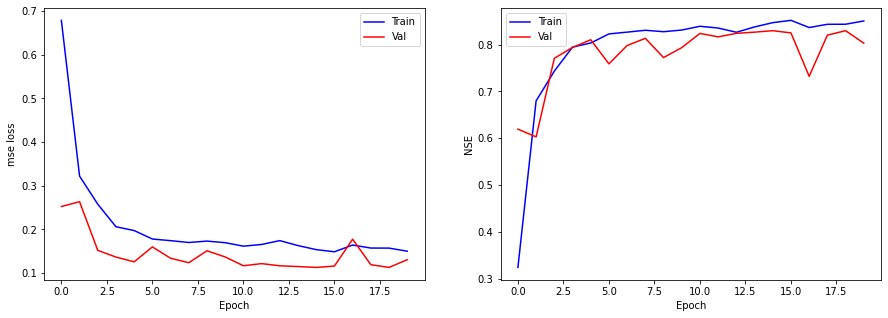

In [51]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(train_loss_history,'b', label='Train')
plt.plot(val_loss_history,'r', label='Val')
plt.xlabel('Epoch')
plt.ylabel('mse loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_nse_history,'b', label='Train')
plt.plot(val_nse_history,'r', label='Val')
plt.xlabel('Epoch')
plt.ylabel('NSE')
plt.legend()

plt.show()

Test NSE: 0.879


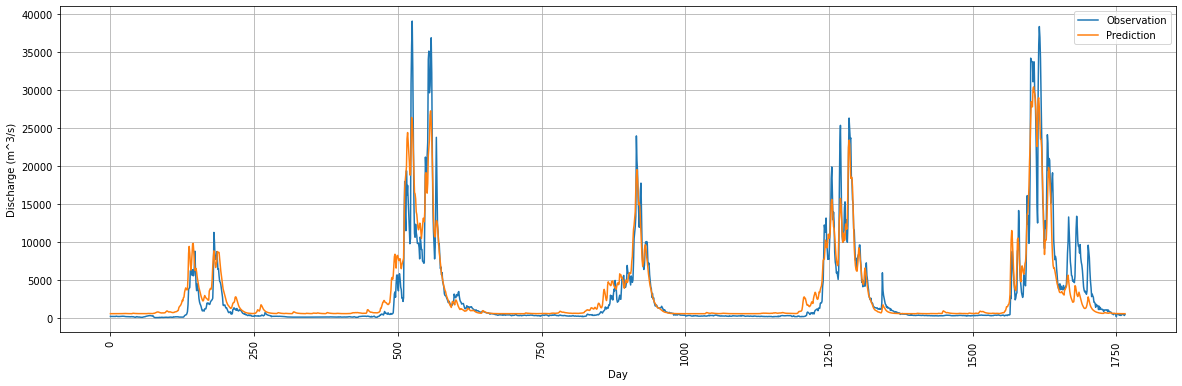

In [27]:
# Apply the final model to the test dataset, print observed vs. prediction and metrics

def test_loop(dataloader, model):
  obs = []
  preds = []

  model.eval()
  with torch.no_grad(): 
    for X, y in dataloader:
      X = X.to(device=device)
      y = y.to(device=device)
      pred = model(X)
      obs.append(y)
      preds.append(pred)

  # Compute obs, preds and metrics of interest
  obs = dataloader.dataset.unnormalize_labels(torch.cat(obs).detach().cpu().numpy())
  preds = dataloader.dataset.unnormalize_labels(torch.cat(preds).detach().cpu().numpy())
  nse = calc_nse(obs,preds)

  return nse, obs, preds

test_nse, test_obs, test_preds = test_loop(test_loader, model)
print(f'Test NSE: {test_nse:.3f}')

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(test_obs, label="Observation")
ax.plot(test_preds, label="Prediction")
ax.legend()
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("Day")
ax.grid('on')
_ = ax.set_ylabel("Discharge (m^3/s)")